## Create figures for real-world experiment.

In [17]:
import torch
import json
from transformers import AutoTokenizer

In [2]:
import os
os.chdir("..")

To run this notebook, first train the models on the IMDB dataset with the script

```
./scripts/train_models.py
```
to train the models on IMDB.

In [40]:
from transformers import AutoTokenizer
import torch
path = "/mnt/ssd3/tobias/AttentionMatricesRaw/models"
run_long = "imdb_bert_2_r7"
# run_long = "imdb_gpt2_2_r7"
from slalom_explanations.transformer_models import Bert, GPT2
if "gpt" in run_long:
    tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=True)
    model_obj = GPT2(n_layers=2, n_heads=12, pretrained=True)
else:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
    model_obj = Bert(n_layers=2, n_heads=12, pretrained=True)

s_dict = torch.load(f"{path}/{run_long}.pt")
model_obj.model.load_state_dict(s_dict)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for an

<All keys matched successfully>

In [78]:
## Load tokens
path = "/mnt/ssd3/tobias/AttentionMatricesRaw/models"

def load_tokens(file_name, stop_sep=False):
    mylist = []
    with open(file_name, 'r') as file:
        for line in file:
            if not stop_sep or ((line.strip("\n") != "[PAD]") and not ('<|endoftext|>' in line)):
                if (line.strip("\n") != "[CLS]") and (line.strip("\n") != "[SEP]"):
                     mylist.append(line.strip("\n"))
    return mylist

def convert_token_list_to_inputs(inp_list, tok):
    """ TODO: make more solid implementation. """
    return tok.convert_tokens_to_ids(inp_list)

In [79]:
data = load_tokens("datasets/sample_00002_bert.txt", stop_sep=True)
inp_list = torch.tensor(convert_token_list_to_inputs(data, tokenizer))

In [80]:
inp_list

tensor([ 2023,  3185,  2001,  2061, 25198,  1012,  2673,  2790, 18114,  1998,
         1045,  2001,  6135,  4810,  2000,  2031,  1037,  2204,  2051,  1012,
         1045,  2012,  2560,  2245,  1045,  1005,  1040,  2022,  2583,  2000,
         3233,  2009,  1012,  2021,  1010,  1045,  2001,  3308,  1012,  2034,
         1010,  1996,  6881,  7077,  2075,  1029,  2009,  2001,  2066,  3666,
         1000,  2637,  1005,  1055,  4569, 15580,  2102,  2188,  6876,  1000,
         1012,  1996,  4365,  3008,  1012,  1045,  6283,  2068,  2061,  2172,
         1012,  1996, 12991,  1011,  5171,  7402,  2155,  1029,  1045,  2342,
         2000,  3713,  2007,  1996,  2711,  3625,  2005,  2023,  1012,  2057,
         2342,  2000,  2031,  1037,  2831,  1012,  2008,  2210,  2611,  2040,
         2001,  2467,  5689,  2006,  2619,  1029,  1045,  2074,  6283,  2014,
         1998,  2018,  2000,  5254,  2009,  1012,  2085,  1010,  1996,  2345,
         3496,  9099, 23865,  2015,  1010,  1045,  2442,  2360, 

In [59]:
from slalom_explanations.attribution_methods import SLALOMLocalExplanantions
myslalomeff = SLALOMLocalExplanantions(model_obj.model, device="cuda:3", sgd_lr= 1e-2, sgd_epochs= 50, modes = ["importance", "value"], n_samples = 5000, seq_len= 2, pad_token_id=(50256 if "gpt" in run_long else 0))

In [60]:
myslalomeff = myslalomeff.get_signed_importance_for_tokens(inp_list)

Pad-Token-ID: 0
14.403760627453835
14.344200219862447
14.280280058669645
14.210379656643198
14.133356591536709
14.048121440714645
13.953648517565373
13.848992885816331
13.733295289686039
13.605793363677481
13.46583364766062
13.31289676092406
13.1466354515561
12.96693356723751
12.773999929418569
12.568467400529064
12.35145834011954
12.12456337764505
11.88974194938437
11.649169358231925
11.405069381222217
11.159557341349323
10.91452238587831
10.671554986607234
10.431920848838681
10.196563530980589
9.966137507874297
9.74104681085215
9.521500140439022
9.307561021665997
9.09920105066059
8.896338129209672
8.698866606872347
8.506673422512916
8.31964302607053
8.137658486793129
7.96060099689368
7.78834976340478
7.620783029047875
7.457776750213419
7.299203677799102
7.144936026388413
6.994844994311363
6.848804036775485
6.706691991113853
6.5683928309008905
6.433796119358048
6.302797014869877
6.175293384490163
6.051186582622923


In [61]:
slalom_weights = {}
for i, k in enumerate(data):
    if k in slalom_weights:
        continue
    else:
        slalom_weights[k] = myslalomeff[:, i]

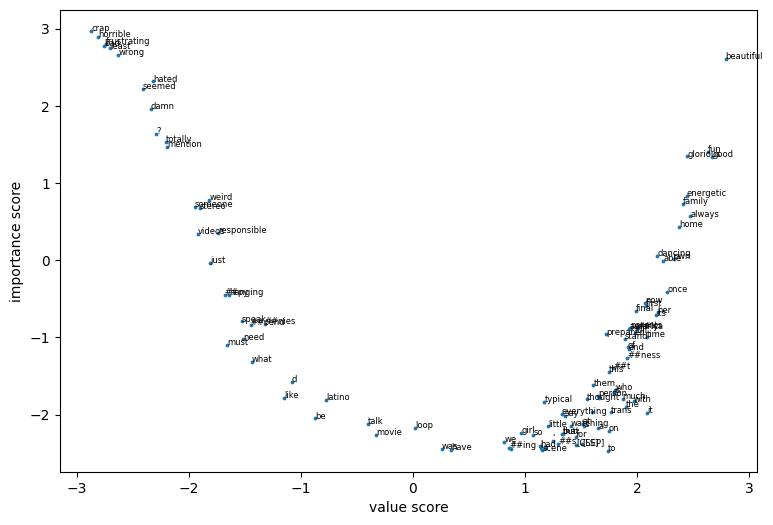

In [65]:
# First scatter plot
tok_list = []
import matplotlib.pyplot as plt
for k, v in slalom_weights.items():
    tok_str = k
    tok_str = tok_str.replace("Ġ", "")
    tok_list.append(tok_str)
    plt.scatter([v[1]], [v[0]], 3, c="tab:blue")
    plt.annotate(tok_str, xy=(v[1], v[0]), fontsize=6)
plt.xlabel("value score")
plt.ylabel("importance score")
plt.gcf().set_size_inches(9,6)
#plt.gcf().savefig(f"figures/E_scatter_id{sample_id}_{run}.pdf")
#plt.plot([-2, 2], [-2,2], "--k")

In [66]:
print_toks = {(2, "bert"):
                  (["fun", "bad", "crap", "horrible", "someone", "the", "beautiful", "energetic", "fun", "for", "this", "person", "family"], 0.5, 0.4),
              (2, "gpt"):
                  (["frustrating", "bad", "crappy", "-rible", "the", "beautiful", "energetic", "hated", "for", "person", "family"], 3.2, 0.2)}

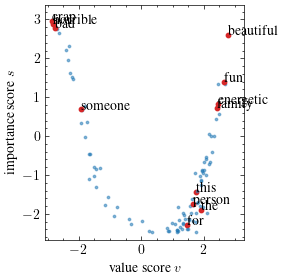

In [70]:
# First scatter plot
sample_id=2
import matplotlib.pyplot as plt
plt.style.use('./figures/matplot.mplstyle')
max_v = max([v[1] for v in slalom_weights.values()])
max_s = max([v[0] for v in slalom_weights.values()])
min_v = min([v[1] for v in slalom_weights.values()])
min_s = min([v[0] for v in slalom_weights.values()])
for k, v in slalom_weights.items():
    tok_str = k
    if run=="gpt":
        if tok_str[0] != "Ġ":
            tok_str = "-" + tok_str
    tok_str = tok_str.replace("Ġ", "")

    if tok_str in print_toks[(sample_id, run)][0]:
        plt.scatter([v[1]], [v[0]], 10, c="tab:red")
        plt.annotate(tok_str, xy=(v[1], v[0]))
    else:
        plt.scatter([v[1]], [v[0]], 3, c="tab:blue", alpha=0.5)
plt.xlim([min_v-0.2, max_v+print_toks[(sample_id, run)][1]])
plt.ylim([min_s-0.2, max_s+print_toks[(sample_id, run)][2]])
plt.grid(None)
plt.xlabel(r"value score $v$")
plt.ylabel(r"importance score $s$")
plt.gcf().set_size_inches(3,3)
plt.tight_layout()
#plt.gcf().savefig(f"figures/f_{run}_{sample_id}_scatter.pdf")

## Text Highlight plots

In [75]:

from matplotlib.colors import Normalize
import matplotlib as mpl
def visualize_attention(att_mat, decoded_tokens, start_pos_y, max_len=50, vmax=5):
    '''
    s_pos: from which token the attention should be visualized (usually the CLS token)
    start_pos_y: for visalizing multiple rows
    max_len: how many tokens should be visualized
    '''
    # average over all heads
    #att_mat = att_mat.sum(axis=1)/att_mat.shape[1]
    #cls_atts = np.flip(att_mat[:,s_pos], axis=0)
    cls_atts = att_mat[:max_len]


    fig, ax = plt.subplots(figsize=(7, 4.9))
    rend = fig.canvas.get_renderer()
    pos_x = 15
    max_x = 500
    pos_y = start_pos_y
    whitespace = 10
    norm = Normalize(vmin=-vmax, vmax=vmax)
    #cmap = plt.cm.YlOrRd
    #cmap = plt.cm.bwr
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","white","green"])
    plt.xlim([0, max_x+50])
    for token, att in zip(decoded_tokens, cls_atts):
        bb = dict(boxstyle="square, pad=0.2", fc=cmap(norm(att)), alpha=0.6)
        text = plt.text(pos_x, pos_y, token.replace("##", "").replace("Ġ", ""), color='black', bbox=bb, fontsize=12)
        pos_x += text.get_window_extent(renderer=rend).width + whitespace

        if pos_x > max_x:
            pos_x = 15
            pos_y -= 25
    plt.ylim([pos_y-40, start_pos_y+15])
    #cax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Adjust these values as needed
    #cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    #cb.set_label('Attention Score', fontsize=10)
    #cb.ax.tick_params(axis='both', labelsize=10)


    ax.set_facecolor('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    plt.show()
    return fig, ax

In [76]:
from slalom_explanations.attribution_methods import SLALOMLocalExplanantions
myslalomeff = SLALOMLocalExplanantions(model_obj.model, device="cuda:3", sgd_lr= 1e-2, sgd_epochs= 50, modes = ["lin"], n_samples = 5000, seq_len= 2, pad_token_id=(50256 if "gpt" in run_long else 0))

In [82]:
myslalomeff = myslalomeff.get_signed_importance_for_tokens(inp_list)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Pad-Token-ID: 0
14.370841109830295
14.27996876349477
14.184022969790076
14.080903515185359
13.969492875483674
13.84884216275345
13.718194812851507
13.577041613621477
13.425177304438439
13.262739949440991
13.090226117120327
12.908473115386226
12.718607160286076
12.521963156541194
12.319988902796343
12.114144982008623
11.905821078314396
11.696276910773193
11.486610269578593
11.2777504342185
11.070465564860196
10.865376437000988
10.66297460384368
10.463635975258216
10.267641417266319
10.075187717940226
9.886404382662526
9.701365706879786
9.52010151188739
9.342608827117848
9.168857864595608
8.99880133465103
8.83237921921717
8.669523264512272
8.510160292031589
8.354214699303117
8.201610800177905
8.052273127505634
7.906128548071021
7.763105787367361
7.623135953291495
7.486152948090857
7.352093610663729
7.220896484569786
7.092503026588247
6.966857018758458
6.843902590150769
6.7235863587134705
6.605855793980009
6.490660087859167


In [88]:
myslalomeff

array([[ 1.59418449e-01, -3.59917581e-02,  2.82580778e-02,
         1.16448849e-01, -3.22894859e+01,  1.52090341e-01,
         1.62435532e-01, -1.26939068e+01,  4.16411686e+00,
         2.64016390e-01,  1.78933442e-01,  2.82580778e-02,
        -7.59610939e+00,  2.61070460e-01,  1.28764629e-01,
         6.62132353e-02,  1.43106982e-01,  1.03726788e+01,
         4.40673381e-01,  1.52090341e-01,  1.78933442e-01,
         1.97908193e-01, -2.62291069e+01,  2.00996563e-01,
         1.78933442e-01,  1.54796630e-01, -9.50239301e-02,
        -1.47579918e-02,  1.63840449e+00,  1.28764629e-01,
         2.90586203e-01,  2.80654997e-01,  1.52090341e-01,
         1.16107143e-01,  1.86766550e-01,  1.78933442e-01,
         2.82580778e-02, -2.31724586e+01,  1.52090341e-01,
         5.15116930e-01,  1.86766550e-01,  2.95471370e-01,
        -1.74323082e+00,  3.24975140e-02,  9.14698169e-02,
        -8.34326935e+00,  2.80654997e-01,  2.82580778e-02,
        -6.34679720e-02,  1.78607568e-01,  8.14304799e-0

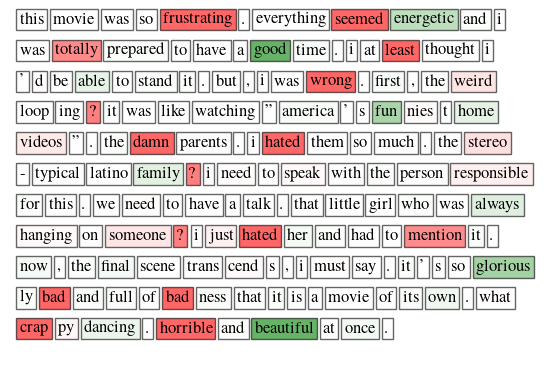

In [89]:
f, ax = visualize_attention(myslalomeff.flatten(), data, start_pos_y=500, max_len=200, vmax=10)

In [90]:
f.savefig(f"figures/f_highlight_{run}_{sample_id}.pdf")